In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from propagation import laser
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/100um/'

In [2]:
pulseParams = {'Nx' : 2**10,
               'Ny' : 2**10,
               'Nt' : 2**6,
               'X' : 16e3,
               'Y' : 16e3,
               'T' : 100,
               'lam' : 0.8,
               'path' : path,
               'name' : 'GaussianBeam',
               'threads' : 4,
               'cyl' : True,
               'tau' : 35}

beam = laserbeam.Laser(pulseParams)
pulseParams['name'] = 'GaussianPulse'
pulse = laserpulse.Pulse(pulseParams)

plasmaParams = {'Nx' : pulseParams['Nx'],
                'Ny' : pulseParams['Ny'],
                'Nz' : 2**8,
                'X' : pulseParams['X'],
                'Y' : pulseParams['Y'],
                'Z' : 2.0e6,
                'n0': 0.25,
                'atom' : ionization.Ar,
                'path' : path,
                'name' : 'Plasma',
                'cyl' : True}

argon = plasma.UniformPlasma(plasmaParams)

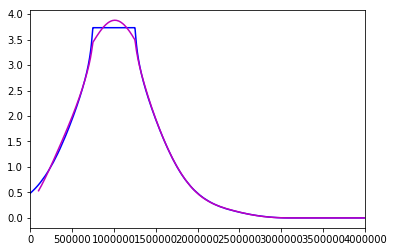

In [3]:
# Create the desired intensity profile
lam = 0.8
ion = {'atom' : ionization.Ar,
       'tau' : pulseParams['tau'],
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

params = {
    'Nr' : 5000,
    'R' : pulseParams['X']*.75,
    'w' : 200,
    'lam' : 0.8
}
r, E = bessel.bessel_expansion(params, z, I)
zFres = np.linspace(1e5, 6e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(abs(eFres))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(z, I, 'b-', zFres, IFres, 'm-')
plt.xlim([0, 4e6])
plt.subplot(122)
plt.plot(r, E)
plt.show()

e = beam.reconstruct_from_cyl(r, E, beam.x, beam.y)
beam.initialize_field(e)
e = e[None, :, :] * np.exp(-pulse.t[:, None, None]**2 * np.pi/(2*pulse.tau**2))
pulse.initialize_field(e)

In [4]:
beam.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)

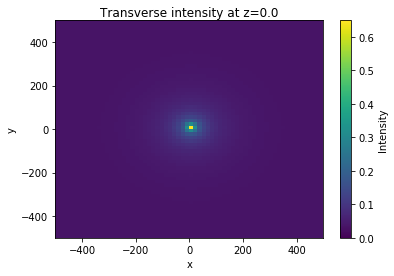

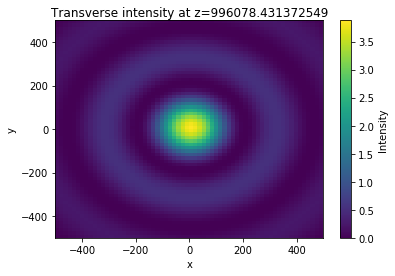

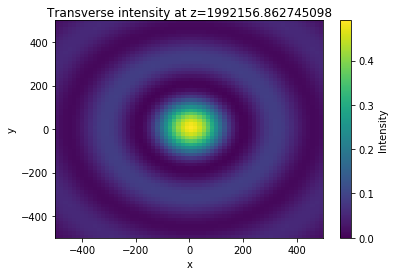

In [5]:
lim = [-500, 500]
beam.plot_intensity_at(1, lim=lim)
beam.plot_intensity_at(int(plasmaParams['Nz']/2), lim=lim)
beam.plot_intensity_at(plasmaParams['Nz']-1, lim=lim)

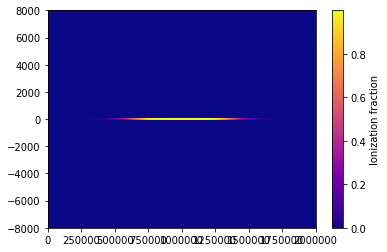

In [6]:
# Lets check the plasma density without refraction
Nx = pulseParams['Nx']
Nz = plasmaParams['Nz']
X = pulseParams['X']
Z = plasmaParams['Z']
e = np.zeros((Nx, Nz-1), dtype='complex128')
for i in range(1, Nz):
    e[:, i-1], temp = beam.load_field(i)
atom = ionization.Ar
ne = adk.gaussian_frac(atom['EI'], abs(e), pulseParams['tau'], atom['Z'], atom['l'], atom['m'])
plt.imshow(np.flipud(ne), aspect='auto', extent=[0, Z, -X/2, X/2], cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.show()

In [7]:
interactions.pulse_plasma(pulse, argon)

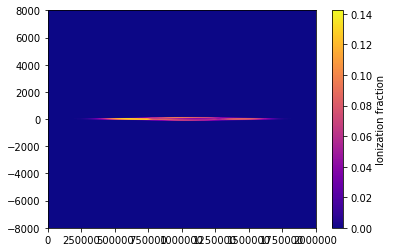

In [8]:
# Lets check the plasma density without refraction
Nt = pulseParams['Nt']
Nx = pulseParams['Nx']
Nz = plasmaParams['Nz']
X = pulseParams['X']
Z = plasmaParams['Z']
e = np.zeros((Nx, Nz-1), dtype='complex128')
for i in range(1, Nz):
    eload, temp = pulse.load_field(i)
    e[:, i-1] = eload[int(Nt/2), :]
atom = ionization.Ar
ne = adk.gaussian_frac(atom['EI'], abs(e), pulseParams['tau'], atom['Z'], atom['l'], atom['m'])
plt.imshow(np.flipud(ne), aspect='auto', extent=[0, Z, -X/2, X/2], cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.show()

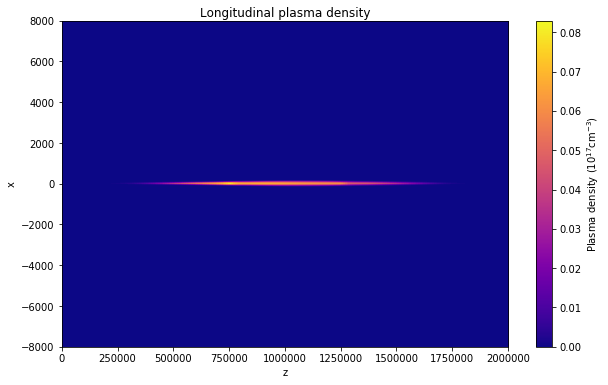

In [9]:
argon.plot_long_density_center()